# Image Similarity Modeling and Analysis with PyTorch

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Train](#Train)
1. [Batch Inference](#Inference)

---

## Background

In this notebook you will build a model to measure the similarity between products from the Zappos product catalog. This notebook uses the [UT Zappos50k](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/) data set provided by University of Texas at Austin. The data has been processed and was scraped off the Zappos.com website, and is intended for non-commerical use.

In this example, we will leverage a CNN based siamese network to learn the similarity function between the products in the catalog. The model is built on PyTorch and trained on SageMaker, and uses transfer learning techniques to leverage pre-trained ResNet models. Finally, the notebook demonstrates how to use SageMaker's Batch Inference functionality to produce a batch of similiarity measures between images using the trained siamese network.

For more information about the PyTorch in SageMaker, please visit [sagemaker-pytorch-containers](https://github.com/aws/sagemaker-pytorch-containers) and [sagemaker-python-sdk](https://github.com/aws/sagemaker-python-sdk) Github repositories.

---

## Setup

_This notebook was tested on an ml.t2.2xlarge, ml.p2.xlarge notebook instance._

Let's start by creating a SageMaker session and specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See [the documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the sagemaker.get_execution_role() with appropriate full IAM role arn string(s).


In [2]:
import os
import sagemaker

SOURCE_DIR='source/similarity'
WORKING_DIR = os.getcwd()

sagemaker_session = sagemaker.Session()

SAGEMAKER_BUCKET = sagemaker_session.default_bucket()
SAGEMAKER_BUCKET_PREFIX = '/sagemaker/DEMO-pytorch-siamese-network/data'

role = sagemaker.get_execution_role()
DATA_S3URI = "s3://"+SAGEMAKER_BUCKET+SAGEMAKER_BUCKET_PREFIX

print("Your SageMaker bucket: "+SAGEMAKER_BUCKET)
print("Current working directory: "+WORKING_DIR)
print("S3 location for storing training data: " + DATA_S3URI)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-777141646116


Your SageMaker bucket: sagemaker-us-east-1-777141646116
Current working directory: /home/ec2-user/SageMaker
S3 location for storing training data: s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/data


Take note of your SageMaker bucket. You'll need to reference it later in this lab.

Next, replace <<SET YOUR REGION>> with the name of region you're running your lab in eg)'us-west-2'

In [7]:
#WORKSHOP_REGION = 'us-west-2'
WORKSHOP_REGION = 'us-east-1'

## Data

The original dataset can be downloaded from [UT Zappos50k](http://vision.cs.utexas.edu/projects/finegrained/utzap50k/). The dataset has been made available at the following S3 bucket to offload the original site.

In [9]:
DOWNLOAD_S3URI = "s3://reinvent2018-sagemaker-pytorch"

Let's preview one of the images from the data set.

In [5]:
%%bash -s "$DOWNLOAD_S3URI" "$WORKING_DIR"

mkdir -p $2/ut-zap50k-images-square/Boots/Knee\ High/Anne\ Klein/
aws s3 cp $1/data/raw/Boots/Knee\ High/Anne\ Klein/8059298.310.jpg $2/ut-zap50k-images-square/Boots/Knee\ High/Anne\ Klein/

download: s3://reinvent2018-sagemaker-pytorch/data/raw/Boots/Knee High/Anne Klein/8059298.310.jpg to ut-zap50k-images-square/Boots/Knee High/Anne Klein/8059298.310.jpg


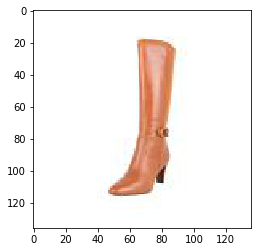

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

img = Image.open(os.path.join(WORKING_DIR,"ut-zap50k-images-square/Boots/Knee High/Anne Klein/8059298.310.jpg"))
plt.imshow(img)

### Uploading the data to S3

We are going to transfer a subset of the Zappos50k dataset over to the default SageMaker bucket in your account. Training on the entire dataset will take hours on GPU as it involves training on a very large dataset of image pair combinations. The goal of this notebook is to demonstrate the process by training on a small subet of the images. 

All the images, processed inputs, and indexes for the entire dataset are publicly shared in the same S3 download location if you wish to experiment on the entire dataset. [Utility scripts](https://github.com/dylan-tong-aws/pytorch-image-similarity/blob/master/notebooks/pytorch_siamese_network_utils.ipynb) have also been made public for you to leverage if you wish to generate your own indexes and pre-processed dataset (npy tensors). 

First we download a subset of sample images that is practical within the scope of the workshop to experience the training and inference process.

In [286]:
import time
import pandas as pd

SAMPLE_TRAINING_IMG_PATHS = "sample_training_images.csv"
os.system("aws s3 cp "+DOWNLOAD_S3URI+"/data/sample/"+SAMPLE_TRAINING_IMG_PATHS + " "+WORKING_DIR)
df = pd.read_csv(os.path.join(WORKING_DIR,SAMPLE_TRAINING_IMG_PATHS), header=None, usecols=[0], names=['img'])
IMG_PATHS = df['img'].tolist()

start = time.time()

for paths in IMG_PATHS :
    esc_path = paths.replace(' ','\ ')
    os.system('aws s3 sync ' + (DOWNLOAD_S3URI+"/data/raw/"+esc_path) +
              ' '+ DATA_S3URI+'/'+esc_path +
              ' --quiet --source-region us-west-2 --region '+ WORKSHOP_REGION)

end = time.time()
print("Sync completed in "+ str(int(end - start))+" seconds")

Sync completed in 34 seconds


### PyTorch DataSet indexes

Now we copy over index files that have been generated for you. These indexes will be used by the training script to locate selected images during training.

The script expects indexes named as follows for the training and test sets respectively:
-  zappos50k-tuples-index-train.csv
-  zappos50k-tuples-index-test.csv

In [15]:
%%bash -s "$DOWNLOAD_S3URI" "$DATA_S3URI" "$WORKSHOP_REGION"

aws s3 cp $1/index/zappos50k-partial-tuples-index-test.csv $2/ --source-region us-west-2 --region $3
aws s3 cp $1/index/zappos50k-partial-tuples-index-train.csv $2/ --source-region us-west-2 --region $3

aws s3 mv $2/zappos50k-partial-tuples-index-train.csv $2/zappos50k-tuples-index-train.csv --quiet
aws s3 mv $2/zappos50k-partial-tuples-index-test.csv $2/zappos50k-tuples-index-test.csv  --quiet

copy: s3://reinvent2018-sagemaker-pytorch/index/zappos50k-partial-tuples-index-test.csv to s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/data/zappos50k-partial-tuples-index-test.csv
copy: s3://reinvent2018-sagemaker-pytorch/index/zappos50k-partial-tuples-index-train.csv to s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/data/zappos50k-partial-tuples-index-train.csv


### Pre-trained model artifacts

Next, we copy over the artifacts for a pre-trained version of the model that we'll be creating in the following steps. This pre-trained model will be used later in the lab.

In [11]:
MODELS_S3URI = "s3://"+SAGEMAKER_BUCKET+'/sagemaker/DEMO-pytorch-siamese-network/model/output'
SOURCE_S3URI = "s3://"+SAGEMAKER_BUCKET+'/sagemaker/DEMO-pytorch-siamese-network/model/source'
MODEL_VERSION = 5

In [13]:
%%bash -s "$DOWNLOAD_S3URI" "$MODELS_S3URI" "$WORKSHOP_REGION" "$MODEL_VERSION" "$SOURCE_S3URI"

START_TIME=$SECONDS

aws s3 sync $1/models/v$4 $2 --source-region us-west-2 --region $3
aws s3 cp $1/source/similarity/sourcedir.tar.gz $5/sourcedir.tar.gz --source-region us-west-2 --region $3

DURATION=$(($SECONDS - $START_TIME))
echo Sync completed in $DURATION seconds

copy: s3://reinvent2018-sagemaker-pytorch/source/similarity/sourcedir.tar.gz to s3://sagemaker-us-east-1-777141646116/sagemaker/DEMO-pytorch-siamese-network/model/source/sourcedir.tar.gz
Sync completed in 2 seconds


## Train

We need to provide a training script that can run on the SageMaker platform. The training script is very similar to a training script you might run outside of SageMaker, but you can access useful properties about the training environment through various environment variables.

A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later. Hyperparameters are passed to your script as arguments and can be retrieved with an argparse.ArgumentParser instance.

In the following steps, scripts are provided to build and train the following model:

### Deep Siamese Network Architecture

<img src="https://s3-us-west-2.amazonaws.com/reinvent2018-sagemaker-pytorch/web/siamese_network_diag.jpg" width="65%" height="65%" align="left"/>

### Preview Results

Before we build and train our model, let's preview some example results from a trained model.

Download a subset of the Zappos50K dataset over to our Notebook instance along with some inference outputs from a pre-trained model.

In [29]:
import os

SAMPLES_S3URI = DOWNLOAD_S3URI+'/data/sample/'

SAMPLE_IMAGES_FILE = "zappos50k-sample-images.zip"
SAMPLE_IMAGES_S3URI = SAMPLES_S3URI+SAMPLE_IMAGES_FILE

OUTPUT_SAMPLES_FILE = "sample-v2-batch-out.zip"
OUTPUT_SAMPLES_S3URI = SAMPLES_S3URI+"batch-workshop/out/"+OUTPUT_SAMPLES_FILE

os.system("aws s3 cp "+SAMPLE_IMAGES_S3URI+" "+WORKING_DIR+" --source-region us-west-2 --region "+WORKSHOP_REGION)
os.system("unzip ./"+SAMPLE_IMAGES_FILE)

os.system("aws s3 cp "+OUTPUT_SAMPLES_S3URI+" "+WORKING_DIR+" --source-region us-west-2 --region "+WORKSHOP_REGION)
os.system("unzip ./"+OUTPUT_SAMPLES_FILE)

0

Now let's load the sample outputs into dataframes...

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

LOCAL_OUTPUT_DIR = os.path.join(WORKING_DIR,'out')
LOCAL_DATA_DIR = os.path.join(WORKING_DIR,'data')
SAMPLE_PRODUCTS = []

def load_sample_outputs() :
    i = 0
    for (root, _, files) in os.walk(LOCAL_OUTPUT_DIR) :
        for f in files :
            fp = os.path.join(root,f)
            df = pd.read_csv(fp, header=None, names=['img','sim'])
            p=fp.replace(LOCAL_OUTPUT_DIR,'').replace('.csv','')
            print(str(i)+": "+p)
            SAMPLE_PRODUCTS.append({"n":p, "sim": df.sort_values(['sim'], ascending=True)})
            i = i+1

            import matplotlib.pyplot as plt
    
def display_similiar_products(product_info) :
    count = 0
    columns = 10
    BATCHES_TO_DISPLAY = 3

    fig = plt.figure(figsize=(columns*2, BATCHES_TO_DISPLAY*3))
    fig.subplots_adjust(wspace=.1)

    products = product_info['sim']
    print(product_info['n'])
    for (index, row) in products[0:columns*BATCHES_TO_DISPLAY].iterrows() :

        count += 1
        ax = fig.add_subplot(BATCHES_TO_DISPLAY, columns, count)   
        ax.set_title(round(row['sim'],5))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.imshow(plt.imread(os.path.join(LOCAL_DATA_DIR,row['img'])))
        
    plt.show()

load_sample_outputs()

0: /Shoes/Oxfords/Bass/7563706.3
1: /Shoes/Oxfords/Rockport/7996677.6194
2: /Shoes/Oxfords/Calvin Klein/7943176.325
3: /Boots/Over the Knee/Calvin Klein Collection/8005712.365488
4: /Boots/Knee High/Anne Klein/8032745.10224
5: /Boots/Knee High/Ariat/7992449.16158
6: /Sandals/Heel/Fly Flot/7418709.9


### Visualize Samples

The output from the cell above lists 7 products, which have pre-generated inferences. Run the cell below to view visually similar products. The first image is the product we're querying, and the products that follow are ordered by similarity (ordered from left to right and top to bottom in descending similarity). Change the index value from 0-6 if you like to preview other products.

In [ ]:
display_similiar_products(SAMPLE_PRODUCTS[2])

### Download the provided scripts

Let's move on to building and training a model. First, we download the scripts:

-  cnn.py: this script implements a siamese network in PyTorch. It uses a pre-trained ResNet model, and replaces the last layer with a dense layer with the number of dimensions as specified by class parameters. All layers except the last have been frozen for training.

-  siamese.py: contains all the training logic. The siamese network takes batches of image pairs, uses the CNN to extract salient features and vectorize the images, and minimizes a contrastive loss function according to the L1 distances between the image vectors and the provided labels.

-  requirements.txt: describes the dependencies that are required by the scripts that aren't pre-installed on the SageMaker PyTorch container. 

In [18]:
%%bash -s "$DOWNLOAD_S3URI" "$SOURCE_DIR" "$WORKSHOP_REGION"

mkdir -p $2
aws s3 cp $1/$2/cnn.py ./$2 --source-region us-west-2 --region $3
aws s3 cp $1/$2/siamese.py ./$2 --source-region us-west-2 --region $3
aws s3 cp $1/$2/requirements.txt ./$2 --source-region us-west-2 --region $3

download: s3://reinvent2018-sagemaker-pytorch/source/similarity/cnn.py to source/similarity/cnn.py
download: s3://reinvent2018-sagemaker-pytorch/source/similarity/siamese.py to source/similarity/siamese.py
download: s3://reinvent2018-sagemaker-pytorch/source/similarity/requirements.txt to source/similarity/requirements.txt


### Model Script

Run the cell below if you like to view the script for the PyTorch model.

In [ ]:
!pygmentize 'source/similarity/cnn.py'

### Training Script

Run the cell below if you like to view the script for training the siamese network on PyTorch:

In [288]:
!pygmentize 'source/similarity/siamese.py'

import argparse
import os
import sys
import time
import copy
import math
import warnings
import csv
import logging

from PIL import Image
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

from cnn import CNN as cnn

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))
    
parser = argparse.ArgumentParser(description='PyTorch CNN Siamese Network')

# Hyperparameters sent by the client are passed as command-line arguments to the script.
parser.add_argument('--batch-size', type=int, default=64, help='mini batch size')
parser.add_argument('--epochs', type=int, default=10, help='number of epochs')
parser.add_argument('--learning-rate', type=float, default=1e-4, help='learning rate')
parser.add_argument('--similarity-dims', type=int, default=64, 
                    help='the number o

### Hyperparameters

Next we define the hyperparameters for our training job. The configurations are set to train on a single epoch. In practice, you'll train for a longer period to obtain better results. In this lab, our goal is to be familiarized with the process.

In [21]:
PARAM_EPOCHS = 1
PARAM_BATCH_SIZE= 64
PARAM_LR = 1e-6
PARAM_SIMILARITY_DIMS = 64
PARAM_SIM_MARGIN = 0.03
PARAM_OPTIMIZER = 'Adam'
PARAM_BEST_MODEL_METRIC = 'test-loss'

HYPERPARAMETERS={
                    'epochs': PARAM_EPOCHS,
                    'batch-size': PARAM_BATCH_SIZE,
                    'learning-rate': PARAM_LR,
                    'similarity-dims': PARAM_SIMILARITY_DIMS,
                    'similarity-margin': PARAM_SIM_MARGIN,
                    'optimizer': PARAM_OPTIMIZER,
                    'best-model-metric' : PARAM_BEST_MODEL_METRIC
                }

### Define the PyTorch Estimator

The provided custom PyTorch training script can be now be trained on SageMaker training servers without further setup. A PyTorch estimator needs to be instantiated as shown below specifying the training script to run, hyperparameters, and the infrastructure to use.

In [22]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="siamese.py",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    train_instance_type='ml.p3.2xlarge',
                    source_dir=SOURCE_DIR,
                    hyperparameters=HYPERPARAMETERS)

### Run the Estimator

The training job is started simply by calling fit() on the estimator, and specifying the location of our training data and indexes. Note that you could specify a different location for your test set, but this isn't necessary as the provided indexes are used to seperate the training and test sets within the provided data corpus.  

    If you train the model without changing the subset of the Zappos50k dataset that has been provided or the parameters given, the training will complete in under an hour using a ml.p3.2xlarge.

In [ ]:
estimator.fit({'train':DATA_S3URI})

## -- OPTIONAL CONTENT ---

Only experiment with the contents below after you have completed the core workshop. The optional content extends well beyond the scope and allocated time for this workshop. The content is for those who like to venture deeper into this project and SageMaker after the completion of the workshop.

## Optional: Programmatic Batch Inference

The workshop guide illustrates the process of launching a batch inference job from the console. The section below illustrates how this can be done programmatically.

Run the cell below to download the script for batch inference.

In [198]:
%%bash -s "$DOWNLOAD_S3URI" "$SOURCE_DIR"
mkdir -p $2
aws s3 cp $1/$2/batch.py ./$2

download: s3://reinvent2018-sagemaker-pytorch/source/similarity/batch.py to source/similarity/batch.py


Run the cell below if you like to view the batch inference script.

In [ ]:
!pygmentize 'source/similarity/batch.py'

Set some constants

In [159]:
BATCH_INPUT_S3URI = DATA_S3URI+"/batch/in"
BATCH_OUTPUT_S3URI = DATA_S3URI+"/batch/out"
BATCH_MODEL_NAME = "batch-zappos50k-siamese-cnn"
BATCH_INSTANCE_TYPE = 'ml.c5.xlarge'

The batch inference job that we're going to create expects inputs in NPY format. The images have been pre-processed by packing pairs of image tensors in NPY format into gzip files, so that images can be sent to a SageMaker Batch Transform job cluster in batches. 

Pre-processed images have been provided for you. Run the cell to download them to your SageMaker bucket, so that your batch inference job has access to the input data.

In [ ]:
%%bash -s "$DOWNLOAD_S3URI" "$BATCH_INPUT_S3URI" "$WORKSHOP_REGION"

start=$SECONDS
aws s3 sync $1/data/sample/batch-workshop/in $2 --quiet --source-region us-west-2 --region $3
duration=$(( SECONDS - start ))

echo sync completed in $duration seconds

### Register a Model for Batch Inference

We need to register a model with SageMaker for the batch inference job. This model uses the batch inference script as the entry point. We'll use the pre-trained model that was downloaded in the previous steps.

In [64]:
from sagemaker.pytorch import PyTorchModel

batchModel = PyTorchModel(model_data=MODELS_S3URI+'/model.tar.gz', 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='batch.py',
                            source_dir=SOURCE_DIR)

batchModel.sagemaker_session = sagemaker_session
container_def = batchModel.prepare_container_def(instance_type=BATCH_INSTANCE_TYPE)
sagemaker_session.create_model(BATCH_MODEL_NAME, role, container_def)

INFO:sagemaker:Creating model with name: batch-zappos50k-siamese-cnn


'batch-zappos50k-siamese-cnn'

### Launch the Batch Inference Job

Now we're ready to run a Batch Inference job. Run the snippet below to launch a batch inference job programmatically.

In [65]:
from sagemaker.transformer import Transformer

transformer = Transformer(model_name=BATCH_MODEL_NAME,
                          instance_count=1,
                          instance_type= BATCH_INSTANCE_TYPE,
                          accept = 'text/csv',
                          output_path=BATCH_OUTPUT_S3URI
                         )
transformer.transform(BATCH_INPUT_S3URI, content_type= 'application/x-npy')

INFO:sagemaker:Creating transform job with name: sagemaker-pytorch-2018-10-24-01-53-45-110


## Optional: Real-time Inference

We can also deploy models in SageMaker for real-time inference. Let's create an endpoint that takes two image tensors and returns the similarity measure between the images as a json output.

First, download the inference script, which will be used as the entry point for a real-time inference model.

In [162]:
%%bash -s "$DOWNLOAD_S3URI" "$SOURCE_DIR"
mkdir -p $2
aws s3 cp $1/$2/inference.py ./$2

download: s3://reinvent2018-sagemaker-pytorch/source/similarity/inference.py to source/similarity/inference.py


Run the cell below if you like to view the real-time inference script.

In [ ]:
!pygmentize 'source/similarity/batch.py'

Run this cell to set a name for our real-time inference endpoint.

In [236]:
RT_ENDPOINT_NAME = "rt-zappos50k-siamese-cnn"

### Deploy Endpoint

Run the following code to register a model, and deploy our endpoint. Note that the configurations utilize the pre-trained model that was downloaded previously.

The model uses the inference.py script as it's entry point.

In [253]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import npy_serializer, json_deserializer

rtModel = PyTorchModel(model_data=MODELS_S3URI+'/model.tar.gz', 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='inference.py',
                            source_dir=SOURCE_DIR)

rtPredictor = rtModel.deploy(instance_type='ml.c5.xlarge', 
                                   initial_instance_count=1,
                                   endpoint_name=RT_ENDPOINT_NAME)
                      
rtPredictor = RealTimePredictor(endpoint=RT_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-777141646116
INFO:sagemaker:Creating model with name: sagemaker-pytorch-2018-10-25-01-28-14-977
INFO:sagemaker:Creating endpoint with name rt-zappos50k-siamese-cnn


---------------------------------------------------------------!

### Use an Existing Endpoint

If you already deployed an real-time endpoint previously, you can run the following code snippet instead of the prevous snippet to acquire a reference to the existing endpoint instead of deploying a new one.

In [205]:
from sagemaker.predictor import RealTimePredictor, npy_serializer, json_deserializer
        
rtPredictor = RealTimePredictor(endpoint=RT_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

Run the cell below to initialize some constants and utility functions

In [289]:
from torchvision import transforms
from PIL import Image

TRANSFORMATIONS = \
transforms.Compose([
    transforms.Resize(224), \
    transforms.ToTensor(), \
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) \
])


PRODUCT = "Boots/Knee High/Anne Klein/8059298.310.jpg"
#PRODUCT = "Shoes/Oxfords/Bass/7563706.3.jpg"
#PRODUCT = "Shoes/Oxfords/Rockport/7996677.6194.jpg"
#PRODUCT = "Shoes/Oxfords/Calvin Klein/7943176.325.jpg"
#PRODUCT = "Boots/Over the Knee/Calvin Klein Collection/8005712.365488.jpg"
#PRODUCT = "Boots/Knee High/Anne Klein/8032745.10224.jpg"
#PRODUCT = "Boots/Knee High/Ariat/7992449.16158.jpg"
#PRODUCT = "Sandals/Heel/Fly Flot/7418709.9.jpg"
#PRODUCT = Shoes/Oxfords/Bass/7563706.3.jpg"

IMG1_LOC = os.path.join(WORKING_DIR,"data/"+PRODUCT)
ZAPPOS50K_SAMPLE_INDEX = "zappos50k-partial-index.csv"

os.system("aws s3 cp "+DOWNLOAD_S3URI+"/index/"+ZAPPOS50K_SAMPLE_INDEX+" "+
      os.path.join(WORKING_DIR,ZAPPOS50K_SAMPLE_INDEX) + 
      " --source-region us-west-2 --region "+ WORKSHOP_REGION)

def getImageTensor(img_path, transform):
    
    image = Image.open(img_path)
    image_tensor = transform(image)
        
    return image_tensor

### Test the Endpoint

Run a quick test comparing an image with itself.

In [ ]:
img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
imgPair= np.vstack((img1,img1))
res= rtPredictor.predict(imgPair)

print(res)

Run the following snippet to display the similar products for our selection in order of most similar.

This is a real-time endpoint and the following code will make api calls a few hundred times comparing the selected product (image) to a few hundred others to capture similarity measures. It will take 5-6 minutes to execute.

In [290]:
import numpy as np
import pandas as pd

img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
df = pd.read_csv(ZAPPOS50K_SAMPLE_INDEX, header=None, usecols=[0], names=['img'])    

for (i,r) in df.iterrows() :
    
    img2 = getImageTensor(LOCAL_DATA_DIR+'/'+r['img'], TRANSFORMATIONS)
    imgPair= np.vstack((img1,img2))
    res= rtPredictor.predict(imgPair)
    df.at[i,'sim'] = float(res['similarity'])

df= df.sort_values(['sim'], ascending=True)

pd.set_option("display.max_rows",10)
display(df)

,img,sim
4,Boots/Knee High/Anne Klein/8059298.310.jpg,0.007968
3,Boots/Knee High/Anne Klein/8032745.310.jpg,0.831515
11,Boots/Knee High/Anne Klein/8032825.310.jpg,0.849758
9,Boots/Knee High/Anne Klein/8032743.310.jpg,0.859110
20,Boots/Knee High/Ariat/7992482.263.jpg,0.865299
...,...,...
145,Sandals/Athletic/Keen Kids/7501314.4535.jpg,0.966350
166,Sandals/Heel/Onex/7622629.10883.jpg,0.966469
174,Sandals/Heel/Onex/7622629.10881.jpg,0.968802
172,Sandals/Heel/Onex/7622650.18.jpg,0.969505


### Visualize

Let's visualize the results.

/home/ec2-user/SageMaker/data/Boots/Knee High/Anne Klein/8059298.310.jpg


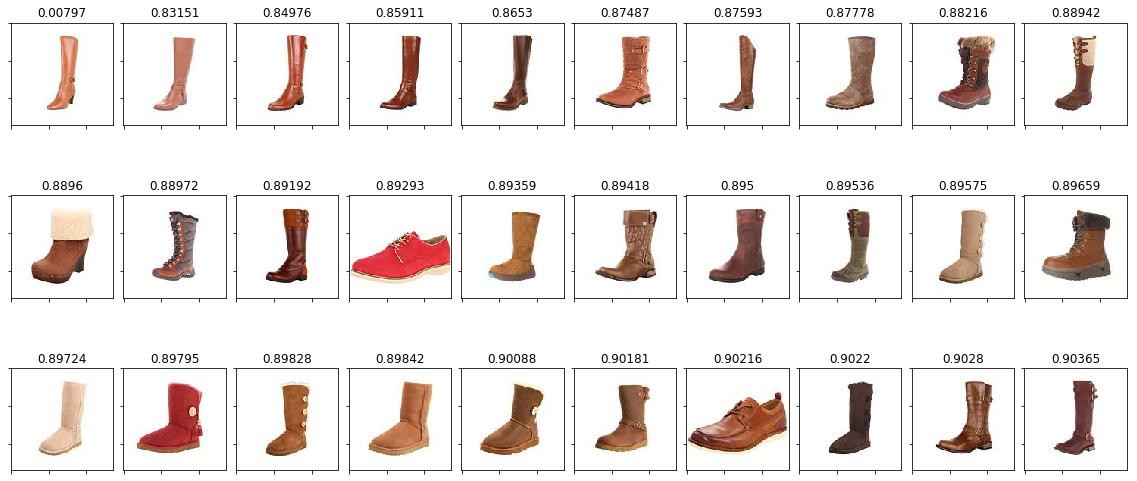

In [291]:
display_similiar_products({"n": IMG1_LOC, "sim": df})

## Optional: Automatic Model Tuning 

Hyperparameters can have substantial effect on the performance and outcome of your model training. A training process traditionally involves a strategy for exploring a range of hyperparameter values in search for a combination that delivers optimal results. 

SageMaker offers a capability call Automatic Model Tuning that performs the process of finding optimal hyperparameters for you by running training jobs in parallel for you and using a Bayesian search strategy to narrow down on the optimal combination of hyperparameters. Ultimately, this reduces the amount of training runs compared to basic hyperparameter search strategies like random search that most data scientists typically use to find optimal hyperparameters, and can lead to discovering parameters that lead to superior results.

The snippets below shows how to launch an hyperparameter tuning job programmatically. You are free to change the base hyperparameters and ranges if you wish. The settings below limit the parallel training jobs to one as it is configured to use GPU instances, and by default, AWS accounts only allow you to launch one of these instance types at a time. If your account has been approved for higher limits, and you are prepared to pay for the training time, you can change the parameters to launch multiple instances and jobs running in parallel to speed up the hyperparameter search process. The default sample datasets with the configurations below will require 40-60 minutes per training job, and run up to a maximum of 30 jobs. You can stop the tuning job from the console to end the process prematurely.

Run the cell below to initialize the base hyperparameters and estimator.

In [283]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter

PARAM_EPOCHS = 8
PARAM_BATCH_SIZE= 64
PARAM_LR = 1e-4
PARAM_SIMILARITY_DIMS = 64
PARAM_SIM_MARGIN = 0.03
PARAM_OPTIMIZER = 'Adam'

HYPERPARAMETERS={
                    'epochs': PARAM_EPOCHS,
                    'batch-size': PARAM_BATCH_SIZE,
                    'learning-rate': PARAM_LR,
                    'similarity-dims': PARAM_SIMILARITY_DIMS,
                    'similarity-margin': PARAM_SIM_MARGIN,
                    'optimizer': PARAM_OPTIMIZER
                }

tuned_estimator = PyTorch(entry_point="siamese.py",
                            role=role,
                            framework_version='0.4.0',
                            train_instance_count=1,
                            train_instance_type='ml.p3.2xlarge',
                            source_dir=SOURCE_DIR,
                            base_job_name='HPO-pytorch',
                            hyperparameters=HYPERPARAMETERS)

### Define Hyperparameter Ranges

Hyperparameter tuning jobs are different from standard training jobs in the sense that you provide the job information about the range of hyperparameters you like to search. The snippet below demonstrates this idea. In this case, we'll explore multiple settings for the training learning rate, the number of dimensions configured in the last layer of the CNN as well as the type of optimizer to use (Adam vs. plain Stochastic Gradient Descent).

Lastly, an objective metric needs to be defined to determine what is the best model. The model that delivers the best results for the defined objective metric is what is ultimately delivered by the tuning job. The configurations below delivers the model and settings that result in the lowest "average training loss.' You are free to define whatever metric you like. For instance, in many cases, validation accuracy is likely what you're optimizing for.

In [287]:
from sagemaker.tuner import HyperparameterTuner

HYPERPARAM_RANGES = {
                        'learning-rate': ContinuousParameter(1e-6, 1e-4),
                        'similarity-dims': CategoricalParameter([16,32,64,96,128]),
                        'optimizer': CategoricalParameter(['Adam','SGD'])
                    }

OBJECTIVE_METRIC_NAME = 'average training loss'
METRIC_DEFINITIONS = [{'Name': 'average training loss',
                       'Regex': 'Training set: Average loss: ([0-9\\.]+)'}]

# Configure HyperparameterTuner
tuner = HyperparameterTuner(estimator=tuned_estimator,
                            objective_metric_name = OBJECTIVE_METRIC_NAME,
                            hyperparameter_ranges  = HYPERPARAM_RANGES,
                            metric_definitions = METRIC_DEFINITIONS,
                            max_jobs=30,
                            max_parallel_jobs=1)

# Start hyperparameter tuning job
tuner.fit({'train': DATA_S3URI})

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-pytorch-181025-0736


### Deploy the Model

You can deploy the best model returned by the tuning job programatically in the same way you would deploy a model produced by a basic training job.

In this case, the model is deployed as a real-time endpoint.

In [ ]:
TUNED_MODEL_DATA = "s3://"+SAGEMAKER_BUCKET+"/"+tuner.best_training_job()+"/output/model.tar.gz"
RT_TUNED_ENDPOINT_NAME = 'HPO-rt-zappos50k'

tuned_model = PyTorchModel(model_data=TUNED_MODEL_DATA, 
                            role=role,
                            framework_version='0.4.0',
                            entry_point='inference.py',
                            source_dir=SOURCE_DIR)

tuned_predictor = tuned_model.deploy(instance_type='ml.c5.xlarge', 
                                   initial_instance_count=1,
                                   endpoint_name=RT_TUNED_ENDPOINT_NAME)
                      
tuned_predictor = RealTimePredictor(endpoint=RT_TUNED_ENDPOINT_NAME,
                                 serializer=npy_serializer,
                                 deserializer= json_deserializer)

### Test the Model

Below are some constants and utilities for testing this model. You can change the value of PRODUCT if you like to visualize the similar products for something different from what is set below.

In [321]:
from torchvision import transforms
from PIL import Image

TRANSFORMATIONS = \
transforms.Compose([
    transforms.Resize(224), \
    transforms.ToTensor(), \
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) \
])


PRODUCT = "Boots/Knee High/Anne Klein/8059298.310.jpg"

IMG1_LOC = os.path.join(WORKING_DIR,"data/"+PRODUCT)
ZAPPOS50K_SAMPLE_INDEX = "zappos50k-partial-index.csv"

os.system("aws s3 cp "+DOWNLOAD_S3URI+"/index/"+ZAPPOS50K_SAMPLE_INDEX+" "+
      os.path.join(WORKING_DIR,ZAPPOS50K_SAMPLE_INDEX) + 
      " --source-region us-west-2 --region "+ WORKSHOP_REGION)

def getImageTensor(img_path, transform):
    
    image = Image.open(img_path)
    image_tensor = transform(image)
        
    return image_tensor

### Display the results

Run the following snippet to display the similar products for our selection in order of most similar.

This is a real-time endpoint and the following code will make api calls a few hundred times comparing the selected product (image) to a few hundred others to capture similarity measures. It will take 5-6 minutes to execute.

In [322]:
import numpy as np
import pandas as pd

img1 = getImageTensor(IMG1_LOC, TRANSFORMATIONS)
df = pd.read_csv(ZAPPOS50K_SAMPLE_INDEX, header=None, usecols=[0], names=['img'])    

for (i,r) in df.iterrows() :
    
    img2 = getImageTensor(LOCAL_DATA_DIR+'/'+r['img'], TRANSFORMATIONS)
    imgPair= np.vstack((img1,img2))
    res= tuned_predictor.predict(imgPair)
    df.at[i,'sim'] = float(res['similarity'])

df= df.sort_values(['sim'], ascending=True)

pd.set_option("display.max_rows",10)
display(df)

,img,sim
4,Boots/Knee High/Anne Klein/8059298.310.jpg,0.011250
11,Boots/Knee High/Anne Klein/8032825.310.jpg,0.980962
3,Boots/Knee High/Anne Klein/8032745.310.jpg,0.982586
9,Boots/Knee High/Anne Klein/8032743.310.jpg,0.983305
37,Boots/Mid-Calf/UGG/8041830.278.jpg,0.985420
...,...,...
262,Boots/Over the Knee/Calvin Klein Collection/80...,0.996999
234,Shoes/Oxfords/Rockport/7805027.325.jpg,0.997084
160,Sandals/Heel/Fly Flot/7418709.585.jpg,0.998830
302,Shoes/Oxfords/Bass/7976075.86183.jpg,0.999740


### Visualize

Let's visualize the results.

* Note that the tuned results probably won't be as good as the provided pre-trained model. The pre-trained model has been trained on the entire Zappos50K data set and on days worth of training time. The training on this lab is only on a subset of the data set. It also uses a [slightly different training algorithm than the one in the lab](https://github.com/dylan-tong-aws/pytorch-image-similarity/blob/master/src/similarity/siamese2.py). 

/home/ec2-user/SageMaker/data/Boots/Knee High/Anne Klein/8059298.310.jpg


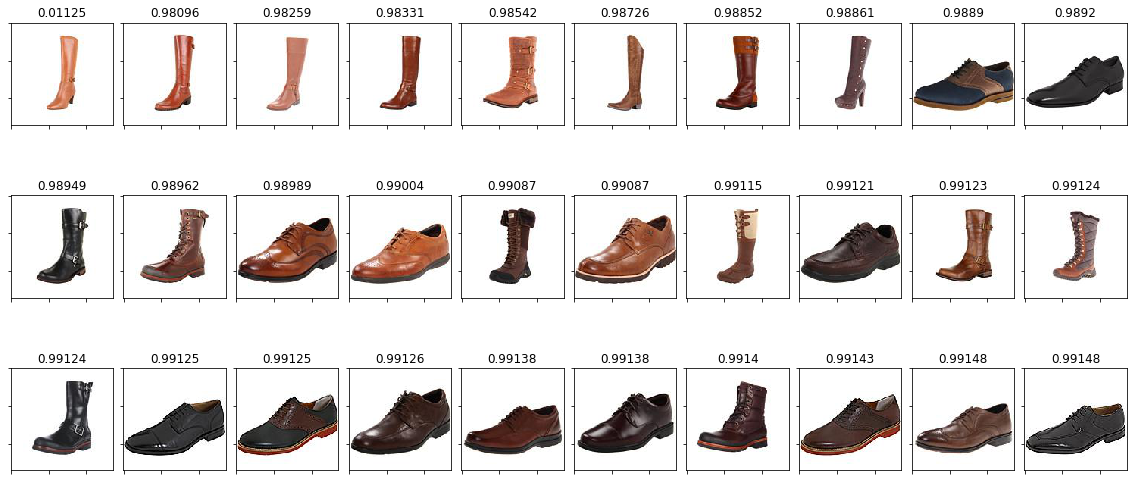

In [323]:
display_similiar_products({"n": IMG1_LOC, "sim": df})